In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings("ignore", category=InterpolationWarning)

# 1. Transforming Data
We first transform the data into logarithms to stabilise the variance and to be able to interpret differenced variables as approximate growth rates. We also re-format the index to monthly data to address formatting issues in the forecasting dataset later on.

In [3]:
df_model = pd.read_csv('data/preprocessed/dataset.csv')

df_log = df_model.copy()

# Converting month to datetime and setting as index
df_log['Month'] = pd.to_datetime(df_log['Month'])
df_log = df_log.set_index('Month')
# Monthly start frequency
df_log = df_log.asfreq('MS')

# Log Transformations
for c in ['CPIH', 'AWE', 'Productivity']:
    if c == 'Productivity':
        df_log['Prod_ln'] = np.log(df_log[c])
    else:
        df_log[f'{c}_ln'] = np.log(df_log[c])

# Creating real wage from wages and productivity
df_log["RealWage_ln"] = df_log["AWE_ln"] - df_log["CPIH_ln"]

display(df_log.head())

,CPIH,AWE,Productivity,CPIH_ln,AWE_ln,Prod_ln,RealWage_ln
Month,,,,,,,
2000-01-01,72.6,304.722925,82.5,4.284965,5.719403,4.412798,1.434438
2000-02-01,72.8,299.818577,82.5,4.287716,5.703178,4.412798,1.415462
2000-03-01,73.0,311.418715,82.5,4.290459,5.741138,4.412798,1.450679
2000-04-01,73.3,308.748756,82.2,4.294561,5.732528,4.409155,1.437967
2000-05-01,73.5,311.178774,82.2,4.297285,5.740368,4.409155,1.443082


# 2. Stationarity Tests
We test for stationarity using both the Augmented Dickey-Fuller test and the KPSS test.

## Augmented Dickey Fuller
We test for stationarity firstly on the level variables. We fail to reject the null for the two variables at the 5% level of significance, the series are non-stationary. We then take the first difference of each variables and we reject the null of non-stationarity at even the 1% level of significance. As such the level variables are of order I(1) and the differenced variables are of order I(0).

In [4]:
# Log column list
cols = ['RealWage_ln', 'Prod_ln']
# Running unit root test for each variable
print("Dickey Fuller Test for log variables")
for col in cols:
    adf_test = adfuller(df_log[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")
# Fail to reject the null of non-stationarity
# Prod_ln can reject then null of unit root at 10% but not 5%

#Taking first difference
df_log_diff = df_log[cols].diff().dropna()

#Running unit roots tests for differenced variables
print("\nDickey Fuller Test for log variables - 1st difference")
for col in cols:
    adf_test = adfuller(df_log_diff[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")
# We reject the null at 1% level, the differenced series are stationary

Dickey Fuller Test for log variables
RealWage_ln : 0.1564494907927585
Prod_ln : 0.09409055828814583

Dickey Fuller Test for log variables - 1st difference
RealWage_ln : 1.0137916327971945e-29
Prod_ln : 1.7210911248880824e-07


# KPSS test
We test the null of stationarity again, around a constant and around a trend. We strongly reject the null for both trend and level stationarity and conclude that the variables are non-stationary.

In [5]:
# Testing for trend stationarity using KPSS
print("\nKPSS Test for log variables (Stationary Around Constant)")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")

print("\nKPSS Test for log variables (Stationary Around Trend)")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='ct', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")


KPSS Test for log variables (Stationary Around Constant)
RealWage_ln KPSS statistic : 1.7572599985305213
RealWage_ln p-value: 0.01

Prod_ln KPSS statistic : 2.5335623841141586
Prod_ln p-value: 0.01


KPSS Test for log variables (Stationary Around Trend)
RealWage_ln KPSS statistic : 0.3105677570830692
RealWage_ln p-value: 0.01

Prod_ln KPSS statistic : 0.3259679746901256
Prod_ln p-value: 0.01



# 3. Plotting ACF and PACF
Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots were plotted for each first-differenced variable. This was done to find the appropriate order of lags and differencing.

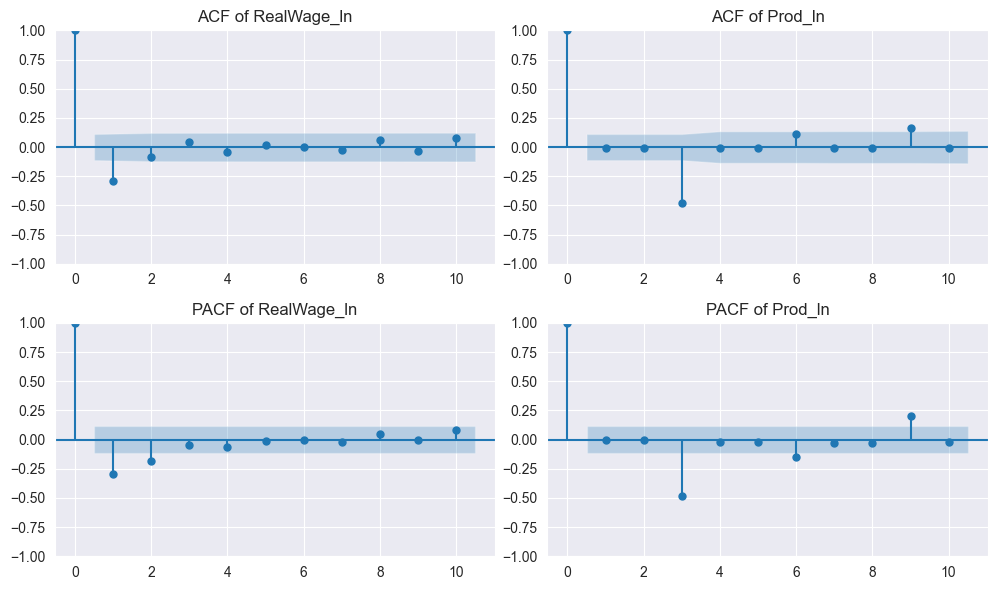

In [6]:
# Setting up plot
fig, axes = plt.subplots(2,2, figsize=(10,6))

for i, col in enumerate(cols):
    # ACF plot with 10 lags - 1st difference
    plot_acf(df_log_diff[col], lags=10, ax=axes[0,i])
    axes[0,i].set_title(f"ACF of {col}")

    # PACF plot with 10 lags
    plot_pacf(df_log_diff[col], lags=10, method="ywm", ax=axes[1,i])
    axes[1,i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()


# Interpetation
There is no evidence in the graphs of persistent higher-order autocorrelation so we do not need to take a second difference.

# 4. Lag Order Selection


In [7]:
# Copying df
joh_data = df_log[cols]

# Specifying VAR model
var_model = VAR(joh_data)

# With monthly data we select 12 lags in line with Otero and Smith (1999)
lag_sel = var_model.select_order(maxlags=12)

print(lag_sel.summary())

# Lags selected by AIC and BIC
l_aic = lag_sel.aic
l_bic = lag_sel.bic
print("Selected lag orders:")
print("AIC: ",l_aic)
print("BIC: ",l_bic)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.70      -13.67   1.125e-06      -13.69
1       -19.29      -19.21   4.199e-09      -19.26
2       -19.33      -19.20   4.036e-09      -19.28
3       -19.34      -19.17   3.985e-09      -19.27
4       -19.59     -19.36*   3.121e-09     -19.50*
5       -19.59      -19.32   3.093e-09      -19.48
6       -19.59      -19.26   3.117e-09      -19.46
7       -19.59      -19.22   3.100e-09      -19.44
8       -19.57      -19.15   3.163e-09      -19.40
9       -19.58      -19.11   3.128e-09      -19.39
10      -19.61      -19.08   3.059e-09      -19.40
11     -19.61*      -19.03  3.058e-09*      -19.38
12      -19.60      -18.98   3.073e-09      -19.35
--------------------------------------------------
Selected lag orders:
AIC:  11
BIC:  4


# 5. Cointegration Test
Now that all the variables are stationary of order I(1) and we have a candidate lag set we test for cointegration, a long-term equilibrium relationship between two or more variables. We test using the Johansen trace test with lag orders from 1 to 5. We then compare the trace statistic to the 5% critical value to determine the rank of cointegration.

In [8]:
# Creating list of lag orders -- includes l=12 for
lags = [int(l_aic), int(l_bic), 12]

# Converting lag orders to Johansen k_ar_diff
joh_lags = []

for lag in lags:
    joh_lags.append(lag - 1)

print("Candidate lags: ", sorted(joh_lags))

# Running test and iterating over deterministic terms and lag candidates

# det = 0 -> constant   det = 1 -> linear trend
for det in [0,1]:
    print('\nDETERMINISTIC ORDER =', det)
    for lag in sorted(joh_lags):
        joh = coint_johansen(joh_data, det_order=det, k_ar_diff=lag)
        print(f"\nLags: {lag}")
        for r in range(len(cols)):

            # Johansen test trace statistic
            trace = joh.lr1[r]

            cv10  = joh.cvt[r, 0]   # 10% critical value
            cv5   = joh.cvt[r, 1]   # 5% critical value
            cv1   = joh.cvt[r, 2]   # 1% critical value

            rej10 = "Reject" if trace > cv10 else "Fail"
            rej5 = "Reject" if trace > cv5 else "Fail"
            rej1 = "Reject" if trace > cv1 else "Fail"

            display(
                f"H0: r <= {r} | trace = {trace:.3f} | "
                f"cv10 = {cv10:.3f} -> {rej10} | "
                f"cv5  = {cv5: .3f} -> {rej5} | "
                f"cv1  = {cv1: .3f} -> {rej1} | "
            )


Candidate lags:  [3, 10, 11]

DETERMINISTIC ORDER = 0

Lags: 3


'H0: r <= 0 | trace = 13.454 | cv10 = 13.429 -> Reject | cv5  =  15.494 -> Fail | cv1  =  19.935 -> Fail | '

'H0: r <= 1 | trace = 4.684 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Reject | cv1  =  6.635 -> Fail | '


Lags: 10


'H0: r <= 0 | trace = 11.290 | cv10 = 13.429 -> Fail | cv5  =  15.494 -> Fail | cv1  =  19.935 -> Fail | '

'H0: r <= 1 | trace = 3.436 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Fail | cv1  =  6.635 -> Fail | '


Lags: 11


'H0: r <= 0 | trace = 10.884 | cv10 = 13.429 -> Fail | cv5  =  15.494 -> Fail | cv1  =  19.935 -> Fail | '

'H0: r <= 1 | trace = 3.012 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Fail | cv1  =  6.635 -> Fail | '


DETERMINISTIC ORDER = 1

Lags: 3


'H0: r <= 0 | trace = 14.941 | cv10 = 16.162 -> Fail | cv5  =  18.398 -> Fail | cv1  =  23.148 -> Fail | '

'H0: r <= 1 | trace = 6.784 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Reject | cv1  =  6.635 -> Reject | '


Lags: 10


'H0: r <= 0 | trace = 11.321 | cv10 = 16.162 -> Fail | cv5  =  18.398 -> Fail | cv1  =  23.148 -> Fail | '

'H0: r <= 1 | trace = 4.941 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Reject | cv1  =  6.635 -> Fail | '


Lags: 11


'H0: r <= 0 | trace = 10.547 | cv10 = 16.162 -> Fail | cv5  =  18.398 -> Fail | cv1  =  23.148 -> Fail | '

'H0: r <= 1 | trace = 3.834 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Fail | cv1  =  6.635 -> Fail | '

# Interpetation
## Deterministic order 0 (constant)
### Lag = 3
+ $r \leq 0$ -> reject at 10%, fail at %
+ $r \leq 1$ -> reject at 10% & 5%

What we are interested in is $r \leq 0$ since we only have two variables. At 10% level of signifiance we can reject $r \leq 0$, so there is some evidence of cointegration with a conservative lag specification.

### Lag = 10, 11
Fail to reject at all levels of significance. At higher lag orders we have no evidence of cointegration.

## Deterministic order 1 (trend)
### All lags
We fail to reject $r \leq 0$ at all levels so we cannot conclude anything from the tests on $r \leq 1$. The cointegration rank here is 0, no evidence of cointegration.



# Implications for Model Selection
According to our results, there is only evidence of cointegration at lower lag orders, with a deterministic order of 0, and only at 10% level of significance. Since our variables are I(1) and there is weak evidence of cointegration we will prefer a **VAR in first differences model** over a VECM.

# 6. Model Specification and First Estimate
We will now take the differenced data and select the appropriate lag order to run a VAR(p) model. We calculate the information criteria and prefer the more parsimonious BIC lag specification of **3** lags. As such we fit a VAR(3) model. We are estimating:

## Real Wage Growth Equation
$$ \begin{align}
\Delta RW_t &= \alpha_0
+ \alpha_1 \Delta RW_{t-1}
+ \alpha_2 \Delta RW_{t-2}
+ \alpha_3 \Delta RW_{t-3} \\
&\quad + \beta_1 \Delta Prod_{t-1}
+ \beta_2 \Delta Prod_{t-2}
+ \beta_3 \Delta Prod_{t-3}
+ \varepsilon_{1t}
\end{align} $$

## Productivity Growth Equation
\begin{align}
\Delta Prod_t &= \gamma_0
+ \gamma_1 \Delta RW_{t-1}
+ \gamma_2 \Delta RW_{t-2}
+ \gamma_3 \Delta RW_{t-3} \\
&\quad + \delta_1 \Delta Prod_{t-1}
+ \delta_2 \Delta Prod_{t-2}
+ \delta_3 \Delta Prod_{t-3}
+ \varepsilon_{2t}
\end{align}



In [9]:
# Copying differenced data
var_data = df_log_diff

# Selecting lag length
lag_sel_diff = VAR(var_data).select_order(12)
print(lag_sel_diff.summary())

# Selecting parsimonious BIC specification - 3 lags
p_opt = lag_sel_diff.bic

# Fitting VAR
var_model = VAR(var_data).fit(p_opt)
print(var_model.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -19.24      -19.21   4.413e-09      -19.23
1       -19.30      -19.23   4.144e-09      -19.27
2       -19.32      -19.20   4.057e-09      -19.27
3       -19.57     -19.40*   3.155e-09     -19.50*
4       -19.59      -19.36   3.117e-09      -19.50
5       -19.58      -19.30   3.140e-09      -19.47
6       -19.58      -19.26   3.125e-09      -19.45
7       -19.57      -19.19   3.185e-09      -19.41
8       -19.57      -19.14   3.170e-09      -19.40
9      -19.60*      -19.13  3.071e-09*      -19.41
10      -19.60      -19.07   3.088e-09      -19.39
11      -19.59      -19.02   3.108e-09      -19.36
12      -19.57      -18.95   3.159e-09      -19.32
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Feb

# VAR Summary Interpetation

## Real Wage Growth Equation
| Variable    | Coefficient  |
|-------------|--------------|
| L1.RealWage | -0.348 (***) |
| L2.RealWage | -0.216 (***) |
| L3.RealWage | -0.047       |
| L1.Prod_ln  | 0.137 (*)    |
| L2.Prod_ln  | 0.079        |
| L3.Prod_ln  | 0.101        |

The first two coefficients on the lagged real wage terms are negative and significant, we have strong negative autocorrelation. Shocks to wage growth are mean reverting in the short run, a positive shock last period will be offset in the following periods. The interpretation is that wage growth does not persist, it adjusts to a baseline level.

The first coefficient of the lagged log productivity term is statistically significant at a 10% level of significance, while the other terms are insignificant. There is weak evidence of productivity growth increasing real wage growth in the short run.

## Productivity Growth Equation
| Variable    | Coefficient  |
|-------------|--------------|
| L1.RealWage | 0.043        |
| L2.RealWage | 0.001        |
| L3.RealWage | 0.014        |
| L1.Prod_ln  | -0.014       |
| L2.Prod_ln  | -0.017       |
| L3.Prod_ln  | -0.482 (***) |

The only significant coefficient, with strong significance is productivity's third lag. As such we have that productivity growth does not respond to wage growth as the real wage terms are not significantly different from 0, and that productivity shocks have strong negative adjustments after three periods. The interpretation is that productivity shocks reverse after 3 months.

# 7. Residual Diagnostics
We will test the model for residual autocorrelation, stability and normality.

In [22]:
print("-------- Portmanteau Test --------")
print(var_model.test_whiteness(nlags=12), "\n")

print("-------- Stability Test --------")
print("Stable:", var_model.is_stable())
print(var_model.roots, '\n')

print("-------- Normality Test --------")
print(var_model.test_normality())


-------- Portmanteau Test --------
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 12 is zero: reject at 5% significance level. Test statistic: 69.501, critical value: 50.998>, p-value: 0.001> 

-------- Stability Test --------
Stable: True
[-4.29315805-0.j         -0.27383789+2.27765664j -0.27383789-2.27765664j
  0.6244458 +1.11643629j  0.6244458 -1.11643629j -1.26854777-0.j        ] 

-------- Normality Test --------
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 29788.015, critical value: 9.488>, p-value: 0.000>


# Diagnostics Intepretation
## Portmatneau Test (Residual Autocorrelation)
$ H_0 : \text{No residual autocorrelation up to 12 lags} $

We reject residual autocorrelation at 5% level of signifiance but not 1% level of signifiance. **There is strong evidence of serial correlation in our residuals.** Based on this result, our model is underfitting so we will need to re-estimate with more lags.

## Stability Test
The test concludes that the model is stable, all roots are inside the unit circle.

## Normality Test
$ p-value: 0.000 $
We strongly reject the null of normally distributed residuals, our residuals are not normally distributed. This is not fatal and likely the case of structural breaks e.g. COVID crisis

The key result was serial autocorrelation in the resduals. The model is underspecified, we will need to add more lags

# 8. Updating The Model
Since we found that our model was underfitting, we will use the AIC specification which includes 9 lags instead of 3. We then test for residual autocorrelation again and find that we fail to reject the null at th 10% level of significance, we have evidence that our residuals are no longer autocorrelated.

In [23]:
# Selecting parsimonious AIC specification - 9 lags
opt_aic = lag_sel_diff.aic

# Fitting VAR
var_model_aic = VAR(var_data).fit(opt_aic)

print("-------- Portmanteau Test --------")
print(var_model_aic.test_whiteness(nlags=12), "\n")

print("-------- Stability Test --------")
print("Stable:", var_model_aic.is_stable())

-------- Portmanteau Test --------
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 12 is zero: fail to reject at 5% significance level. Test statistic: 17.364, critical value: 21.026>, p-value: 0.136> 

-------- Stability Test --------
Stable: True


# 9. Impulse Response Functions
Cholesky, ordering, ...

Index(['RealWage_ln', 'Prod_ln'], dtype='object')


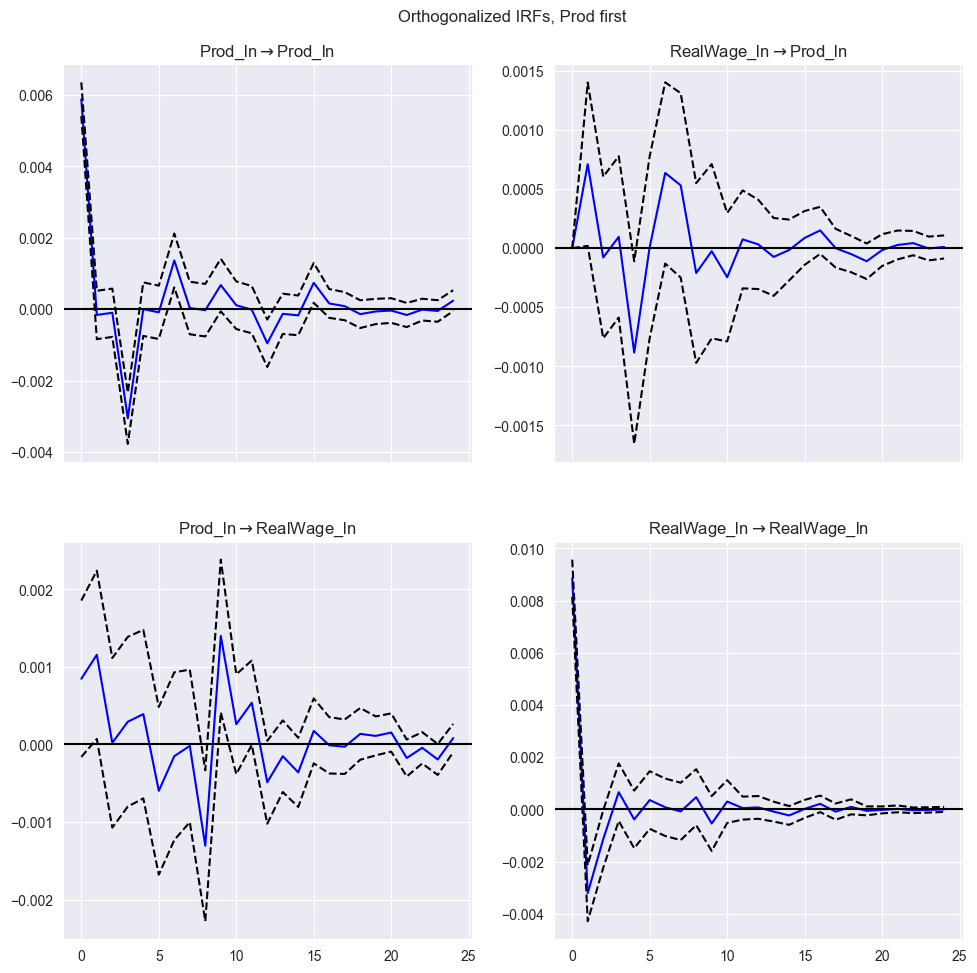

In [29]:
# Displaying ordering of columns
print(var_data.columns)

# Rearranging columns
var_data_ord = var_data[['Prod_ln', 'RealWage_ln']]

# Optimal AIC lags
var_final = VAR(var_data_ord).fit(opt_aic)

#Compute IRFs
horizon = 24
irf = var_final.irf(horizon)

# Plot orthogonalized IRFs (Cholesky)
irf.plot(orth=True)
plt.suptitle(f"Orthogonalized IRFs, Prod first")
plt.show()

# 10. FEVD (Forecast Error Variance Decomposition)

FEVD for Prod_ln
       Prod_ln  RealWage_ln
0     1.000000     0.000000
1     0.985619     0.014381
2     0.985449     0.014551
3     0.988305     0.011695
4     0.971263     0.028737
5     0.971267     0.028733
6     0.964118     0.035882
7     0.958426     0.041574
8     0.957542     0.042458
9     0.957927     0.042073
10    0.956740     0.043260
11    0.956631     0.043369
12    0.957415     0.042585
13    0.957323     0.042677
14    0.957345     0.042655
15    0.957663     0.042337
16    0.957250     0.042750
17    0.957256     0.042744
18    0.957225     0.042775
19    0.956994     0.043006
20    0.956990     0.043010
21    0.956999     0.043001
22    0.956964     0.043036
23    0.956967     0.043033

FEVD for RealWage_ln
       Prod_ln  RealWage_ln
0     0.009072     0.990928
1     0.022642     0.977358
2     0.022329     0.977671
3     0.023133     0.976867
4     0.024706     0.975294
5     0.028404     0.971596
6     0.028639     0.971361
7     0.028641     0.971359
8     0.0

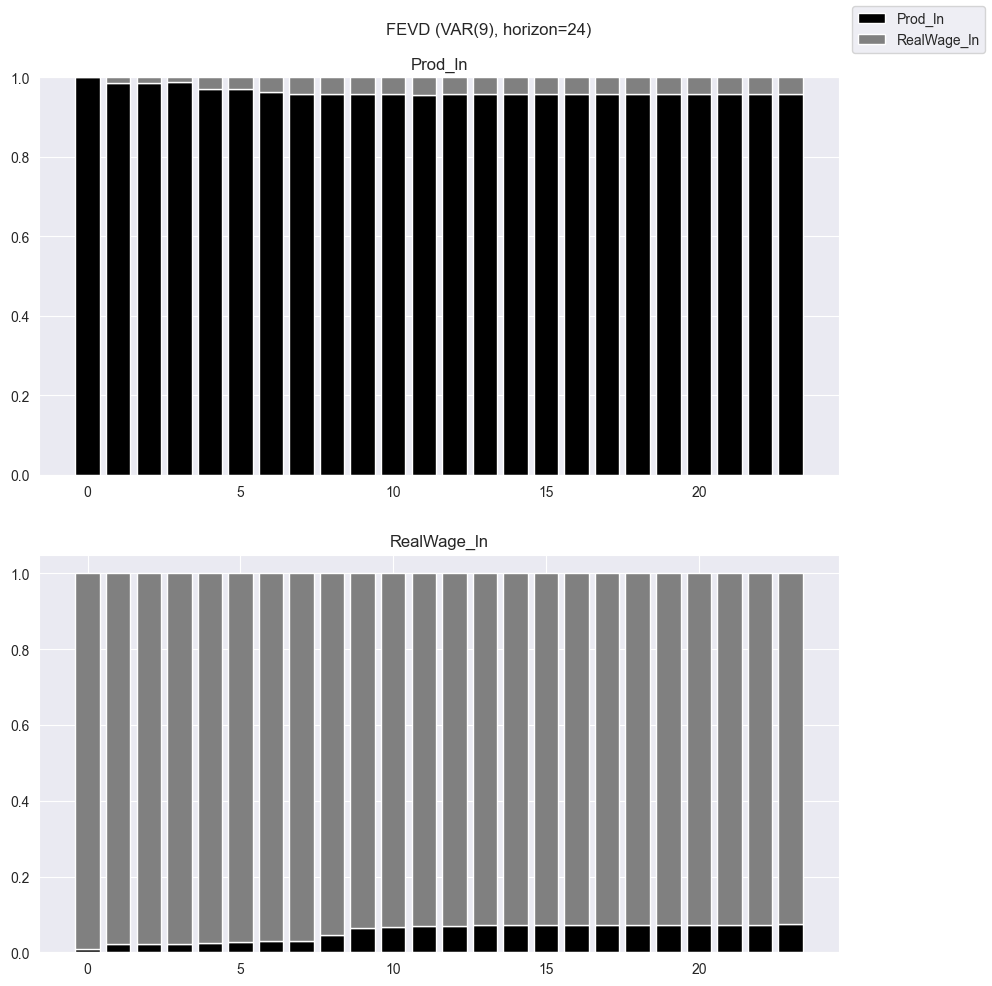

In [31]:
h = 24  # 24 months
fevd = var_final.fevd(h)

print(fevd.summary())

# Plot FEVD
fevd.plot()
plt.suptitle(f"FEVD (VAR({p}), horizon={h})")
plt.show()